In [26]:
!pip3 install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore') 

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Importing & Inspecting Data

In [27]:
sms = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='ISO-8859-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [28]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Pre-processing Data

In [29]:
sms = sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms.columns=['labels', 'data']

In [30]:
sms.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [31]:
X = sms['data']
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: data, Length: 5572, dtype: object

In [32]:
y = sms['labels'].map({'ham': 0, 'spam': 1}).values
y

array([0, 0, 1, ..., 0, 0, 0])

## Exploring Data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42,stratify=y)

## Text Pre-processing

In [34]:
tokenizer=Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

In [35]:
seq_train=tokenizer.texts_to_sequences(X_train)
len(seq_train)

3733

In [36]:
seq_test = tokenizer.texts_to_sequences(X_test)
len(seq_test)

1839

In [37]:
data_train = pad_sequences(seq_train)
data_train

array([[   0,    0,    0, ...,    7, 2254,   13],
       [   0,    0,    0, ...,  598, 2256, 2257],
       [   0,    0,    0, ...,   13, 3396,   11],
       ...,
       [   0,    0,    0, ..., 3272, 7238, 2609],
       [   0,    0,    0, ...,  396,   17,   85],
       [   0,    0,    0, ..., 3336,  337,   68]], dtype=int32)

In [38]:
data_train.shape

(3733, 162)

In [39]:
data_test = pad_sequences(seq_test, maxlen=data_train.shape[1])
data_test

array([[   0,    0,    0, ...,   80,   33,  203],
       [   0,    0,    0, ...,    6,  168, 5410],
       [   0,    0,    0, ...,  172,    5,  259],
       ...,
       [   0,    0,    0, ...,  635,  812,  491],
       [   0,    0,    0, ..., 6898,  748,  212],
       [   0,    0,    0, ...,   93,    9,  292]], dtype=int32)

In [40]:
data_test.shape

(1839, 162)

## Model Training & Building

In [41]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [42]:
# Input layer
i = Input(shape=(data_train.shape[1],))  # input layer takes in sequences of integers

# Embedding layer
x = Embedding(len(tokenizer.word_index) + 1, 20)(i) # This takes in sequences of integers and returns sequences of word vectors

# LSTM layer
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)

# Dense layer
x = Dense(1, activation='sigmoid')(x)
# it is an binary classification problem, so we are using activation function ='sigmoid'

model = Model(i, x)

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
hist = model.fit(x=data_train, y=y_train, epochs=20, validation_data=(data_test, y_test))

Epoch 1/20
117/117 [==============================] - 10s 61ms/step - loss: 0.4716 - accuracy: 0.8548 - val_loss: 0.2964 - val_accuracy: 0.8657
Epoch 2/20
117/117 [==============================] - 6s 56ms/step - loss: 0.1763 - accuracy: 0.9464 - val_loss: 0.1251 - val_accuracy: 0.9766
Epoch 3/20
117/117 [==============================] - 7s 57ms/step - loss: 0.0799 - accuracy: 0.9887 - val_loss: 0.0837 - val_accuracy: 0.9831
Epoch 4/20
117/117 [==============================] - 7s 57ms/step - loss: 0.0458 - accuracy: 0.9928 - val_loss: 0.0675 - val_accuracy: 0.9853
Epoch 5/20
117/117 [==============================] - 7s 59ms/step - loss: 0.0279 - accuracy: 0.9957 - val_loss: 0.0576 - val_accuracy: 0.9880
Epoch 6/20
117/117 [==============================] - 6s 55ms/step - loss: 0.0181 - accuracy: 0.9979 - val_loss: 0.0612 - val_accuracy: 0.9859
Epoch 7/20
117/117 [==============================] - 6s 55ms/step - loss: 0.0142 - accuracy: 0.9976 - val_loss: 0.0567 - val_accuracy: 0.987

## Model Evaluation

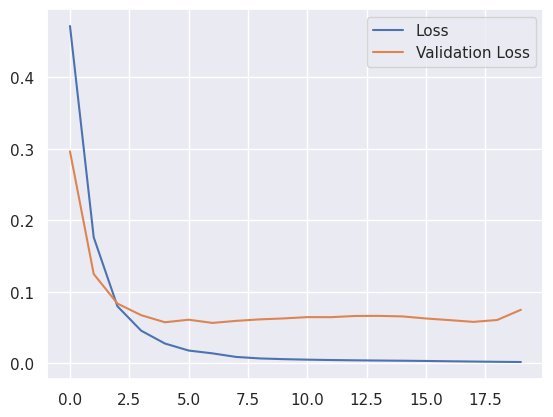

In [45]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

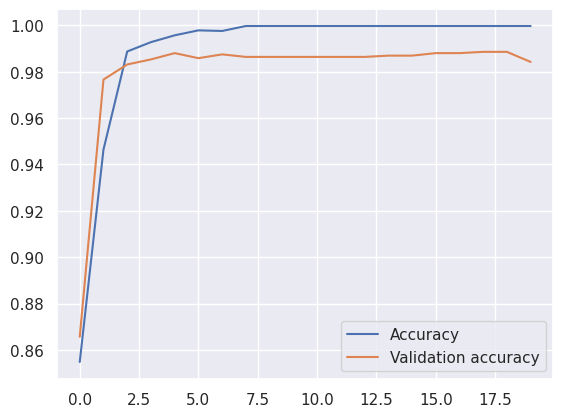

In [46]:
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()